## Pre-Procesing

In [1]:
from preprocessing import train_valid_test_split, combine_labels, get_attribute_dims

In [2]:
# Train-Test Split Folders
SOURCE_DATA_DIR = "data/ClothingAttributeDataset/images/"
TARGET_DATA_DIR = "data/ClothingAttributeDataset/"

# Labels File
LABEL_DIR = "data/ClothingAttributeDataset/labels/"
labels_file = "data/labels.csv"
label_values_file = "data/label_values.json"

# Train and Validation Images
TRAIN_IMAGES_FOLDER = "data/ClothingAttributeDataset/train/"
VALID_IMAGES_FOLDER = "data/ClothingAttributeDataset/valid/"
TEST_IMAGES_FOLDER = "data/ClothingAttributeDataset/test/"

In [3]:
labels_df = combine_labels(LABEL_DIR, labels_file, label_values_file)

In [4]:
# binary_columns = ['skin_exposure_GT', 'collar_GT', 'gender_GT', 'scarf_GT', 'necktie_GT',  'placket_GT']
# multi_columns = ['category_GT', 'neckline_GT', 'sleevelength_GT']
    
# color_columns = ['white_GT', 'yellow_GT', 'gray_GT', 'green_GT', 'blue_GT', 'brown_GT', 'red_GT',
#                  'cyan_GT', 'black_GT', 'purple_GT', 'many_colors_GT']
# pattern_columns = ['pattern_spot_GT', 'pattern_solid_GT', 'pattern_graphics_GT', 
#                   'pattern_plaid_GT', 'pattern_stripe_GT', 'pattern_floral_GT']

## Build Models

In [4]:
from utils import is_gpu_available
from classifiers import get_pretrained_model

In [5]:
target_dims = get_attribute_dims(label_values_file)

In [6]:
target_dims

{'category_GT': 7,
 'collar_GT': 2,
 'gender_GT': 2,
 'neckline_GT': 3,
 'necktie_GT': 2,
 'pattern_GT': 6,
 'placket_GT': 2,
 'scarf_GT': 2,
 'skin_exposure_GT': 2,
 'sleevelength_GT': 3}

In [7]:
use_gpu = is_gpu_available()

## Fully FCN Model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import init

import copy
import time

In [9]:
from preprocessing import make_dsets, get_label_idx_to_name, image_loader
from preprocessing import image_loader, load_label_values
from classifiers import predict_attributes, get_pretrained_model

In [ ]:
init.xavier_normal()

In [10]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_normal(m.weight.data)
#         init.xavier_normal(m.bias.data)

In [ ]:
nn.Linear()

In [28]:
class FCNModel(nn.Module):
    def __init__(self, in_channels, out_dims, return_conv_layer=False):
        super().__init__()
        self.return_conv_layer = return_conv_layer
        model_steps = [
#             nn.BatchNorm2d(in_channels),
#             nn.Conv2d(in_channels, 256, 3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(256, 64, 3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(in_channels, out_dims, 1)
            nn.Linear(512 * 14 * 14, out_dims)
        ]
        self.conv_model = nn.Sequential(*model_steps)

    def forward(self, x):
        # Get Conv Layer output.  Output channels = number of classes
        classes_conv_out = self.conv_model(x)
        classes_softmax = F.softmax(classes_conv_out)
        return F.log_softmax(classes_conv_out)
        
#         # Do Global Average Pooling on the Conv Layer with Number of Channels = Classes
#         pool_size = (classes_conv_out.size(2), classes_conv_out.size(3))
#         average_pool = F.avg_pool2d(classes_conv_out, kernel_size=classes_conv_out.size()[2:])
#         average_pool_flatten = average_pool.view(average_pool.size(0), -1)
#         # print(average_pool_flatten)
#         classes_softmax = F.softmax(average_pool_flatten)
        
        if self.return_conv_layer:
            return classes_conv_out, average_pool_flatten
        else:
            return average_pool_flatten

In [32]:
def optim_scheduler_ft(model, epoch, init_lr=0.01, lr_decay_epoch=7):
    lr = init_lr * (0.1**(epoch//lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print("LR is set to {}".format(lr))

#     optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return optimizer

In [29]:
def train_attribute_model(model, pretrained_model, train_dset_loader,
                          valid_dset_loader=None,
                          criterion=nn.CrossEntropyLoss(),
                          optim_scheduler=optim_scheduler_ft,
                          use_gpu=None,
                          num_epochs=25, 
                          verbose=False,
                          flatten_pretrained_out=False):
    since = time.time()
    best_model = model
    best_acc = 0.0
    if use_gpu is None:
        use_gpu = torch.cuda.is_available()

    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Define Phases and Get the dataset Sizes
    phases = ["train"]
    dset_sizes = {
        "train": len(train_dset_loader.dataset)
    }
    if valid_dset_loader is not None:
        phases.append("valid")
        dset_sizes["valid"] =  len(valid_dset_loader.dataset)

    if use_gpu:
        pretrained_model.cuda()
        model.cuda()

    for epoch in range(num_epochs):
        if verbose:
            print("Epoch {}/{}".format(epoch, num_epochs - 1))

        # Each epoch has a train and validation Phase
        for phase in phases:
            if phase == "train":
#                 optimizer = optim_scheduler(model, epoch)
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data
            dset_loader = valid_dset_loader if phase == "valid" else train_dset_loader
            for data in dset_loader:
                # Get the inputs
                inputs, labels = data

                # Wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                                             Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)



                # Get output from pre-trained model and re-shape to Flatten
                out_features = pretrained_model(inputs)
                if flatten_pretrained_out:
                    out_features = out_features.view(out_features.size(0), -1)

                # Forward
                output = model(out_features)
                loss = F.nll_loss(output, labels)
#                 _, preds = torch.max(outputs.data, 1)
#                 loss = criterion(outputs, labels)
#                 print(loss)
                preds = output.data.max(1)[1]
                # Backward + Optimize only in Training Phase
                if phase == "train":
                    # Zero the parameter gradients
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # Statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == "valid" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

    time_elapsed = time.time() - since
    print("Training completed in {:0f}m {:0f}s".format(
        time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))
    return best_model


In [16]:
train_dset_loader = make_dsets(TRAIN_IMAGES_FOLDER, labels_file, "gender_GT",
                               batch_size=64, num_workers=2, is_train=True, shuffle=True)

valid_dset_loader = make_dsets(VALID_IMAGES_FOLDER, labels_file, "gender_GT",
                        batch_size=32, num_workers=2, is_train=False, shuffle=False)

In [17]:
pretrained_conv_model, _, _ = get_pretrained_model("vgg16", pop_last_pool_layer=True, use_gpu=use_gpu)

In [30]:
model = FCNModel(512, 2, return_conv_layer=True)

In [24]:
model.apply(weights_init)

FCNModel (
  (conv_model): Sequential (
    (0): Linear (100352 -> 2)
  )
)

In [111]:
print(dir(list(model.conv_model.children())[0]))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backend', '_backward_hooks', '_buffers', '_forward_hooks', '_modules', '_parameters', 'add_module', 'apply', 'children', 'cpu', 'cuda', 'dilation', 'double', 'dump_patches', 'eval', 'float', 'forward', 'groups', 'half', 'in_channels', 'kernel_size', 'load_state_dict', 'modules', 'named_children', 'named_modules', 'out_channels', 'output_padding', 'padding', 'parameters', 'register_backward_hook', 'register_buffer', 'register_forward_hook', 'register_parameter', 'reset_parameters', 'share_memory', 'state_dict', 'stride', 'train', 'training', 'transposed', 'type', 'zero_grad']


In [33]:
train_attribute_model(model, pretrained_conv_model, train_dset_loader,
                          valid_dset_loader=valid_dset_loader,
                          criterion=nn.CrossEntropyLoss(),
                          optim_scheduler=optim_scheduler_ft,
                          use_gpu=None,
                          num_epochs=10, 
                          verbose=False,
                          flatten_pretrained_out=True)

train Loss: 0.1780 Acc: 0.8187
valid Loss: 0.6447 Acc: 0.8507
train Loss: 0.1709 Acc: 0.8373
valid Loss: 0.5427 Acc: 0.8731
train Loss: 0.1743 Acc: 0.8291
valid Loss: 0.5148 Acc: 0.8694
train Loss: 0.1516 Acc: 0.8358
valid Loss: 0.5201 Acc: 0.8172
train Loss: 0.1669 Acc: 0.8418
valid Loss: 0.6012 Acc: 0.8396
train Loss: 0.1915 Acc: 0.8314
valid Loss: 0.5898 Acc: 0.8433
train Loss: 0.1858 Acc: 0.8291
valid Loss: 0.5980 Acc: 0.8396
train Loss: 0.1646 Acc: 0.8373
valid Loss: 0.6370 Acc: 0.8433
train Loss: 0.1786 Acc: 0.8425
valid Loss: 0.6010 Acc: 0.8507
train Loss: 0.1916 Acc: 0.8663
valid Loss: 0.6182 Acc: 0.8321
Training completed in 1.000000m 32.208959s
Best val Acc: 0.873134


FCNModel (
  (conv_model): Sequential (
    (0): Linear (100352 -> 2)
  )
)

## Evaluate the Model

In [ ]:
torch.nn.CrossEntropyLoss()

In [34]:
import numpy as np
from scipy.misc import imread, imsave, imresize
from matplotlib import pyplot as plt

%matplotlib inline

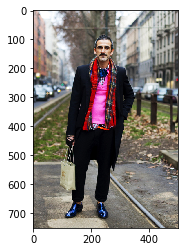

In [70]:
img = imread("data/ClothingAttributeDataset/valid/000006.jpg")
plt.imshow(img)

In [13]:
# use_gpu = torch.cuda.is_available()

# def 
# if use_gpu:
#     pretrained_conv_model = pretrained_conv_model.cuda()
#     for model in attribute_models.values():
#         model.cuda()

In [36]:
label_values = load_label_values(label_values_file)

In [71]:
image_url = "data/ClothingAttributeDataset/valid/000006.jpg"

In [64]:
image_url

'data/ClothingAttributeDataset/valid/000045.jpg'

In [72]:
image_features = image_loader(image_url, use_gpu=True)

In [56]:
image_features.size()

torch.Size([1, 3, 224, 224])

In [57]:
np.mean(image_features.cpu().data.numpy(), axis=(2, 3))

array([[-0.82685876, -0.8692565 , -0.80381399]], dtype=float32)

In [141]:
np.mean(image_features.cpu().data.numpy(), axis=(2, 3))

array([[-0.68798059, -0.64795732, -0.42970389]], dtype=float32)

In [73]:
pretrained_features = pretrained_conv_model(image_features)

In [42]:
pretrained_features.size()

torch.Size([1, 512, 14, 14])

In [77]:
!mkdir weights/vgg16-fcn-266-2/

In [43]:
from torchvision import transforms

In [44]:
transforms.ToPILImage()(pretrained_features[0][0:3].cpu().data)

In [74]:
out_features = pretrained_features.view(pretrained_features.size(0), -1)

In [75]:
outputs = model(out_features)

In [76]:
outputs

Variable containing:
  0.0000 -47.8647
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]

## Visualize FCN

In [23]:
import scipy.misc

In [33]:
conv_layer_out = attribute_models["sleevelength_GT"].conv_model(pretrained_features)

In [34]:
conv_arr2 = conv_layer_out[0].data.cpu().numpy()

In [25]:
conv_arr = conv_layer_out[0].data.cpu().numpy()

In [35]:
np.mean(conv_arr2, axis=(1, 2))

array([-0.14064956, -0.18462452, -0.19912066,  0.39244321,  0.11226825,
       -0.08380169,  0.19703917], dtype=float32)

In [26]:
np.mean(conv_arr, axis=(1, 2))

array([ 0.03558936, -0.21509379, -0.2884874 ,  0.58108062,  0.22265822,
       -0.4062033 ,  0.08262175], dtype=float32)

In [28]:
from torchvision import transforms

In [29]:
image_features.size()

torch.Size([1, 3, 224, 224])

In [55]:
# transforms.ToPILImage()(image_features[0].data.cpu())

In [38]:
image_features[0].data.cpu().numpy().shape

(3, 400, 266)

In [54]:
# plt.imshow(scipy.misc.imresize(scipy.misc.imread(image_url), (400, 266)))

In [75]:
conv_out = conv_layer_out[0].data.cpu().numpy()

In [67]:
conv_out_exp = np.exp(conv_out)

In [68]:
conv_out_sum = np.sum(conv_out_exp, 0)

In [69]:
conv_out_smax = (conv_out_exp / conv_out_sum)

In [37]:
plt.imshow(scipy.misc.imresize(scipy.misc.imread(image_url), (400, 266)))
plt.imshow(scipy.misc.imresize(conv_out[3], (400, 266), interp='nearest'), 
           alpha=0.5, cmap="cool")

NameError: name 'scipy' is not defined

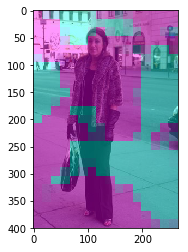

In [71]:
plt.imshow(scipy.misc.imresize(scipy.misc.imread(image_url), (400, 266)))
plt.imshow(scipy.misc.imresize(conv_out_smax[2], (400, 266), interp='nearest'), 
           alpha=0.4, cmap="cool")

## Confusion Matrix

In [57]:
for data in dset_loaders["train"]:
    inputs, labels = data
    if use_gpu:
        X = Variable(inputs.cuda())
    else:
        X = Variable(inputs)
    results = model(X)
    if use_gpu:
        results = results.cpu()
    break

NameError: name 'dset_loaders' is not defined

In [25]:
data = [{"placket_GT": ["Has Placket", "1.0%"], "sleevelength_GT": ["Long sleeves", "1.0%"], "category_GT": ["Suit", "1.0%"], "pattern_GT": ["Solid", "1.0%"], "neckline_GT": ["V-shape", "1.0%"], "collar_GT": ["Has Collar", "1.0%"], "gender_GT": ["Is Male", "1.0%"]}]

In [26]:
import pandas as pd

In [28]:
data

[{'category_GT': ['Suit', '1.0%'],
  'collar_GT': ['Has Collar', '1.0%'],
  'gender_GT': ['Is Male', '1.0%'],
  'neckline_GT': ['V-shape', '1.0%'],
  'pattern_GT': ['Solid', '1.0%'],
  'placket_GT': ['Has Placket', '1.0%'],
  'sleevelength_GT': ['Long sleeves', '1.0%']}]

In [ ]:
for 

In [31]:
df = pd.DataFrame(data[0]).T

In [32]:
df.columns = ["Prediction", "Probability"]

In [35]:
df.index = df.index.str.replace("_GT", "").str.capitalize()

In [36]:
df

,Prediction,Probability
Category,Suit,1.0%
Collar,Has Collar,1.0%
Gender,Is Male,1.0%
Neckline,V-shape,1.0%
Pattern,Solid,1.0%
Placket,Has Placket,1.0%
Sleevelength,Long sleeves,1.0%
